In [64]:
from PIL import Image
from PIL import ImageFile
from PIL import TiffImagePlugin
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [65]:
import torch
from torchvision import transforms
import json
import torch.nn.utils.rnn as run_utils
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# ①Pillow教程
参考文章：https://zhuanlan.zhihu.com/p/132630457

# ②Opencv教程

# ③可视化教程
参考文章：https://zhuanlan.zhihu.com/p/356798637

## (1)Transformer得到相应的热力图
### ①如果你是可视化整个序列的一个平均注意力，那么你可以了解到，这个序列中比较重要的部分
### ②如果你是可视化整个序列中，某一个token的注意力，那热力图的含义就是和这个token对应的最重要的部分

In [115]:
import numpy as np
import cv2
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os

def visualize_grid_attention_v2(img_path,attention_mask,  save_path=None, ratio=1, cmap="jet", save_image=False,
                             save_original_image=False, quality=200):
    """
    img_path:   image file path to load
    save_path:  image file path to save
    attention_mask:  2-D attention map with np.array type, e.g, (h, w) or (w, h)
    ratio:  scaling factor to scale the output h and w
    cmap:  attention style, default: "jet"
    quality:  saved image quality
    """
    print("load image from: ", img_path)
    img = Image.open(img_path, mode='r')
    #img_h, img_w = img.size[0], img.size[1]
    img_h, img_w = 224,224
    plt.subplots(nrows=1, ncols=1, figsize=(0.02 * img_h, 0.02 * img_w))

    # scale the image
    #img_h, img_w = int(img.size[0] * ratio), int(img.size[1] * ratio)
    img_h, img_w = int(224 * ratio), int(224 * ratio)
    img = img.resize((img_h, img_w))
    plt.imshow(img, alpha=1)
    plt.axis('off')

    # normalize the attention map
    mask = cv2.resize(attention_mask, (img_h, img_w))
    normed_mask = mask / mask.max()
    normed_mask = (normed_mask * 255).astype('uint8')
    plt.imshow(normed_mask, alpha=0.5, interpolation='nearest', cmap="jet")

    if save_image:
        # build save path
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        img_name = img_path.split('/')[-1].split('.')[0] + "_with_attention.jpg"
        img_with_attention_save_path = os.path.join(save_path, img_name)

        # pre-process and save image
        print("save image to: " + save_path + " as " + img_name)
        plt.axis('off')
        plt.subplots_adjust(top=1, bottom=0, right=1,  left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        plt.savefig(img_with_attention_save_path, dpi=quality)

    if save_original_image:
        # build save path
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        # save original image file
        print("save original image at the same time")
        img_name = img_path.split('/')[-1].split('.')[0] + "_original.jpg"
        original_image_save_path = os.path.join(save_path, img_name)
        img.save(original_image_save_path, quality=quality)

In [67]:
from models.trf import RobertaEncoder
from transformers import BertConfig, BertForPreTraining, RobertaForMaskedLM, RobertaModel, RobertaConfig, AlbertModel, AlbertConfig


In [68]:
attention_mask = np.random.randn(14, 14)

load image from:  ../data/mm/TV/MVSA_SINGLE/data/1.jpg


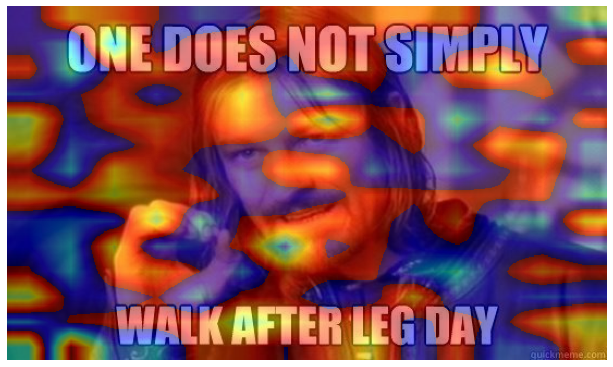

In [69]:
%matplotlib inline
visualize_grid_attention_v2('../data/mm/TV/MVSA_SINGLE/data/1.jpg',attention_mask)

In [70]:
# 下面分别用resnet和trf来进行具体的实践

In [71]:
def get_resize(image_size):
    for i in range(20):
        if 2**i >= image_size:
            return 2**i
    return image_size

In [72]:
image_size=224
transform_base = transforms.Compose(
    [
        transforms.Resize(get_resize(image_size)),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
image_path = '../data/mm/TV/MVSA_SINGLE/data/3.jpg'
image_read = Image.open(image_path)
image_read.load()

image_origin =  transform_base(image_read)

In [74]:
image_origin.shape
image_origin=image_origin.unsqueeze(0)
image_origin.shape

torch.Size([1, 3, 224, 224])

In [75]:
import torch.nn as nn
import torchvision.models as cv_models


In [76]:
class ImageModel(nn.Module):
    def __init__(self, opt):
        super(ImageModel, self).__init__()
        opt.image_model='resnet-18'
        if opt.image_model == 'resnet-152' or True:
            self.resnet = cv_models.resnet152(pretrained=True)
        elif opt.image_model == 'resnet-101':
            self.resnet = cv_models.resnet101(pretrained=True)
        elif opt.image_model == 'resnet-50':
            self.resnet = cv_models.resnet50(pretrained=True)
        elif opt.image_model == 'resnet-34':
            self.resnet = cv_models.resnet34(pretrained=True)
        elif opt.image_model == 'resnet-18' :
            self.resnet = cv_models.resnet18(pretrained=True)
        self.resnet_encoder = nn.Sequential(*(list(self.resnet.children())[:-2]))
        self.resnet_avgpool = nn.Sequential(list(self.resnet.children())[-2])
        self.output_dim = self.resnet_encoder[7][2].conv3.out_channels

        for param in self.resnet.parameters():
            if opt.fixed_image_model:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def get_output_dim(self):
        return self.output_dim

    def forward(self, images):
        image_encoder = self.resnet_encoder(images)
        # image_encoder = self.conv_output(image_encoder)
        image_cls = self.resnet_avgpool(image_encoder)
        image_cls = torch.flatten(image_cls, 1)
        i_1=self.resnet.conv1(images)
        return image_encoder, image_cls,i_1

In [77]:
class O():
    def __init__(self):
        self.image_model='resnet-18'
        self.fixed_image_model=True
        print(self.fixed_image_model)

In [78]:
opt=O()
model=ImageModel(opt)

True


In [79]:
image_encoder, image_cls,ttt=model(image_origin)

In [80]:
image_encoder.shape

torch.Size([1, 2048, 7, 7])

In [81]:
image_cls.shape

torch.Size([1, 2048])

In [82]:
ttt.shape

torch.Size([1, 64, 112, 112])

In [83]:
import time
def draw_features(width,height,x,savename=None):
    tic=time.time()
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05, hspace=0.05)
    for i in range(width*height):
        plt.subplot(height,width, i + 1)
        plt.axis('off')
        img = x[0, i, :, :]
        print(img.shape)
        pmin = np.min(img)
        pmax = np.max(img)
        img = ((img - pmin) / (pmax - pmin + 0.000001))*255  #float在[0，1]之间，转换成0-255
        img=img.astype(np.uint8)  #转成unit8
        img=cv2.applyColorMap(img, cv2.COLORMAP_JET) #生成heat map
        img = img[:, :, ::-1]#注意cv2（BGR）和matplotlib(RGB)通道是相反的
        plt.imshow(img)
        #print("{}/{}".format(i+1,width*height))
    #fig.savefig(savename, dpi=100)
    #fig.clf()
    #plt.close()
    print("time:{}".format(time.time()-tic))

(7, 7)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
(7, 7)
time:0.12799811363220215


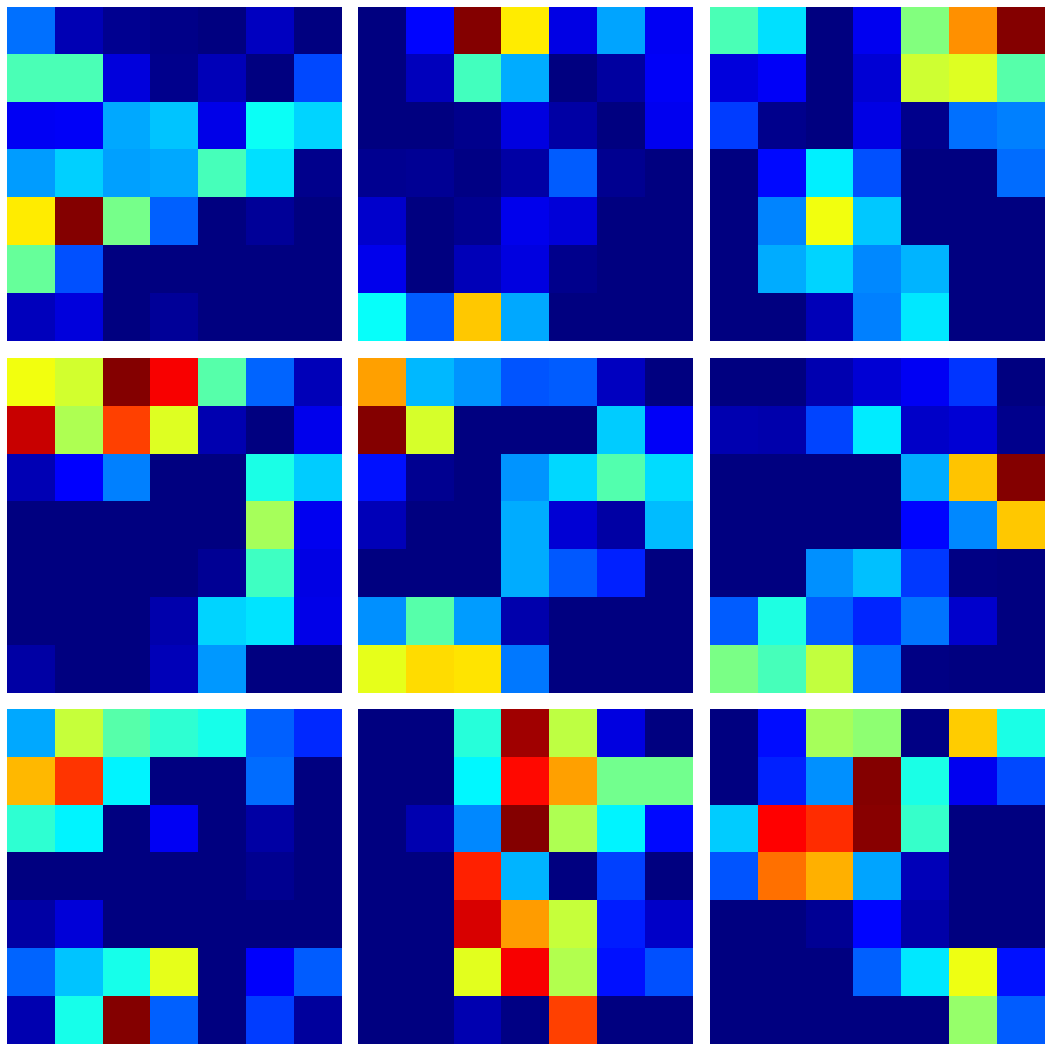

In [84]:
%matplotlib inline
draw_features(3,3,image_encoder.cpu().numpy() )

In [85]:
from torch.nn.functional import conv2d


In [86]:
image_encoder.shape

torch.Size([1, 2048, 7, 7])

In [87]:
CNN_model=nn.Conv2d(in_channels=2048,out_channels=1,kernel_size=1,stride=1)

In [88]:
output_pooled=CNN_model(image_encoder)
output_pooled

tensor([[[[-0.0954, -0.1351, -0.3080, -0.2974, -0.5020, -0.5674, -0.6330],
          [ 0.0958,  0.1096, -0.3042, -0.1928, -0.3737, -0.3452, -0.3519],
          [-0.0758, -0.0102, -0.3651, -0.4291, -0.1869, -0.0433, -0.3016],
          [-0.3578, -0.3105, -0.5789,  0.3417,  0.8581,  0.4166, -0.1566],
          [-0.2642,  0.1768, -0.7180, -0.2443,  0.3098, -0.0513, -0.4049],
          [ 0.2253, -0.5108, -0.6495, -0.3670, -0.0794, -0.2071, -0.3458],
          [ 0.8321,  0.0411, -0.2741, -0.4835, -0.3807, -0.5441, -0.0852]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [89]:
output_pooled.squeeze( ).cpu().detach().numpy()

array([[-0.09541143, -0.1351047 , -0.30801937, -0.2973643 , -0.5020335 ,
        -0.56741554, -0.63297546],
       [ 0.09583679,  0.10956629, -0.30418062, -0.19276398, -0.37367478,
        -0.3452118 , -0.35194916],
       [-0.0757833 , -0.01017507, -0.36514154, -0.42910117, -0.1869223 ,
        -0.04327162, -0.30163273],
       [-0.35779616, -0.3105059 , -0.57885945,  0.34170246,  0.85808104,
         0.41657382, -0.1565647 ],
       [-0.2642437 ,  0.17684373, -0.7179878 , -0.24426898,  0.30981505,
        -0.05128355, -0.40491316],
       [ 0.22531852, -0.5108038 , -0.64945424, -0.3669966 , -0.07941219,
        -0.20711872, -0.345784  ],
       [ 0.832082  ,  0.04109593, -0.27413258, -0.48353451, -0.38073415,
        -0.54410857, -0.08517826]], dtype=float32)

In [90]:
attention_mask

array([[ 0.54274187, -1.38373738, -0.82958295, -0.08708455,  0.91201115,
         0.56646928, -0.95188117, -0.42528565, -0.98808647, -0.98106381,
        -1.07710634,  0.94902366,  0.47184239,  2.32713629],
       [ 0.38969702,  1.42703114, -3.2076056 ,  0.53223457, -0.60031888,
        -0.88678033, -0.35161247, -0.47199153, -0.20230567,  0.97078622,
         0.37290254,  0.13851702,  0.87887175, -0.80388154],
       [-0.58560651,  2.03547286, -0.23337917, -1.07997678, -0.02065143,
        -0.50709794,  0.42250013, -1.07893004, -0.77007464,  1.19714247,
        -0.9050068 , -2.01964127,  0.06700482,  0.12512576],
       [ 0.86348316,  0.18559528, -0.7540987 ,  0.74927003, -0.54559651,
        -1.79293425,  0.8489547 ,  2.0158373 ,  0.04050975,  0.78453339,
         0.35464365,  0.51207388, -0.26230487,  0.72438336],
       [-2.12941125,  0.44860075, -0.76849134, -0.95669897, -0.31154028,
        -1.32281486, -0.08141967, -2.59696731, -0.11910655, -0.69665292,
         1.9929706 ,  0.34

(7, 7)
time:0.01303720474243164


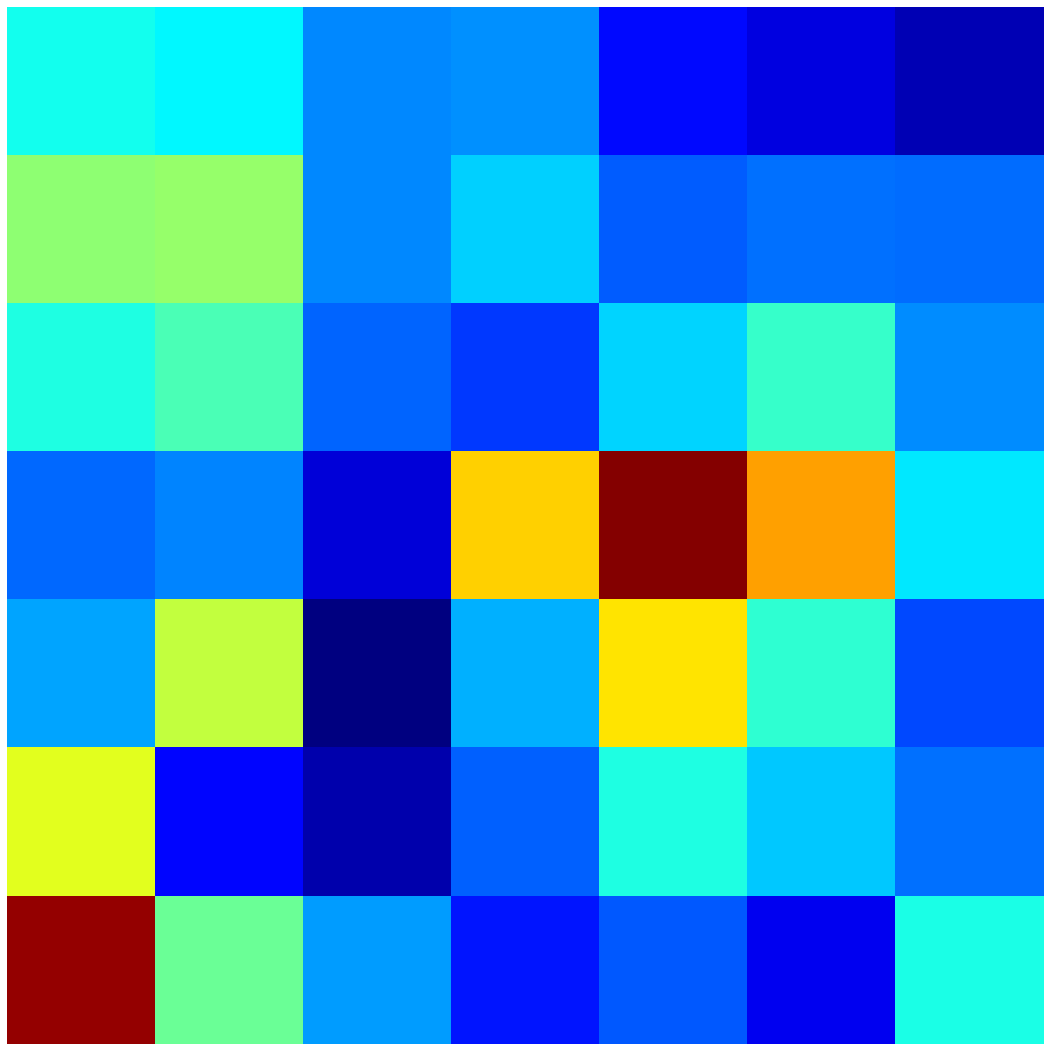

In [91]:
draw_features(1,1,output_pooled.cpu().detach().numpy() )

load image from:  ../data/mm/TV/MVSA_SINGLE/data/3.jpg


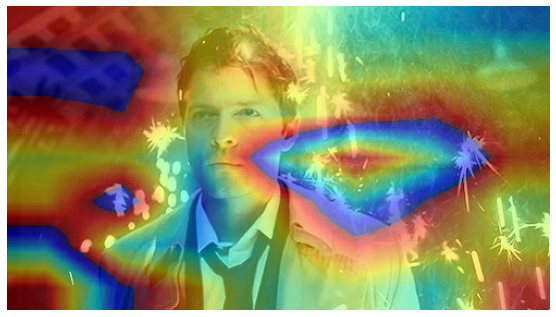

In [92]:
visualize_grid_attention_v2('../data/mm/TV/MVSA_SINGLE/data/3.jpg',output_pooled.squeeze( ).cpu().detach().numpy())

In [93]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model              #用于储存模型
        self.target_layer = target_layer#目标层的名称
        self.gradients = None           #最终的梯度图

    def save_gradient(self, grad):
        self.gradients = grad           #用于保存目标特征图的梯度（因为pytorch只保存输出，相对于输入层的梯度
                                        #，中间隐藏层的梯度将会被丢弃，用来节省内存。如果想要保存中间梯度，必须
                                        #使用register_hook配合对应的保存函数使用，这里这个函数就是对应的保存
                                        #函数其含义是将梯度图保存到变量self.gradients中，关于register_hook
                                        #的使用方法我会在开一个专门的专题，这里不再详述
    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for name,layer in pretrained_model._modules.items():
            if name == "fc":
                break
            x = layer(x)
            if name == self.target_layer:
                conv_output = x                      #将目标特征图保存到conv_output中
                x.register_hook(self.save_gradient)  #设置将目标特征图的梯度保存到self.gradients中
        return conv_output, x                        #x为最后一层特征图的结果

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.fc(x)
        return conv_output, x

In [94]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer) #用于提取特征图与梯度图
    def generate_cam(self, input_image, target_class=None):
        #1.1 前向传播，计算出目标类的最终输出值model_output，以及目标层的特征图的输出conv_output
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        #one hot编码，令目标类置1
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # 步骤1.2 反向传播， 获取目标类相对于目标层各特征图的梯度
        target = conv_output.data.numpy()[0]
        # 步骤1.2.1 清零梯度：model.zero_grad()
        self.model.zero_grad()
        # 步骤1.2.2 计算反向传播
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # 步骤1.2.3 获取目标层各特征图的梯度
        guided_gradients = self.extractor.gradients.data.numpy()[0]

        # 步骤2.1 对每张梯度图求均值，作为与其对应的特征图的权重
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # 初始化热力图
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # 步骤2.2 计算各特征图的加权值
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        #步骤2.3 对热力图进行后处理，即将结果变换到0~255
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

In [95]:
resnet = cv_models.resnet18(pretrained=True)

In [98]:
image_origin.shape

torch.Size([1, 3, 224, 224])

torch.Size([1, 512, 7, 7])
(7, 7)
time:0.014598369598388672


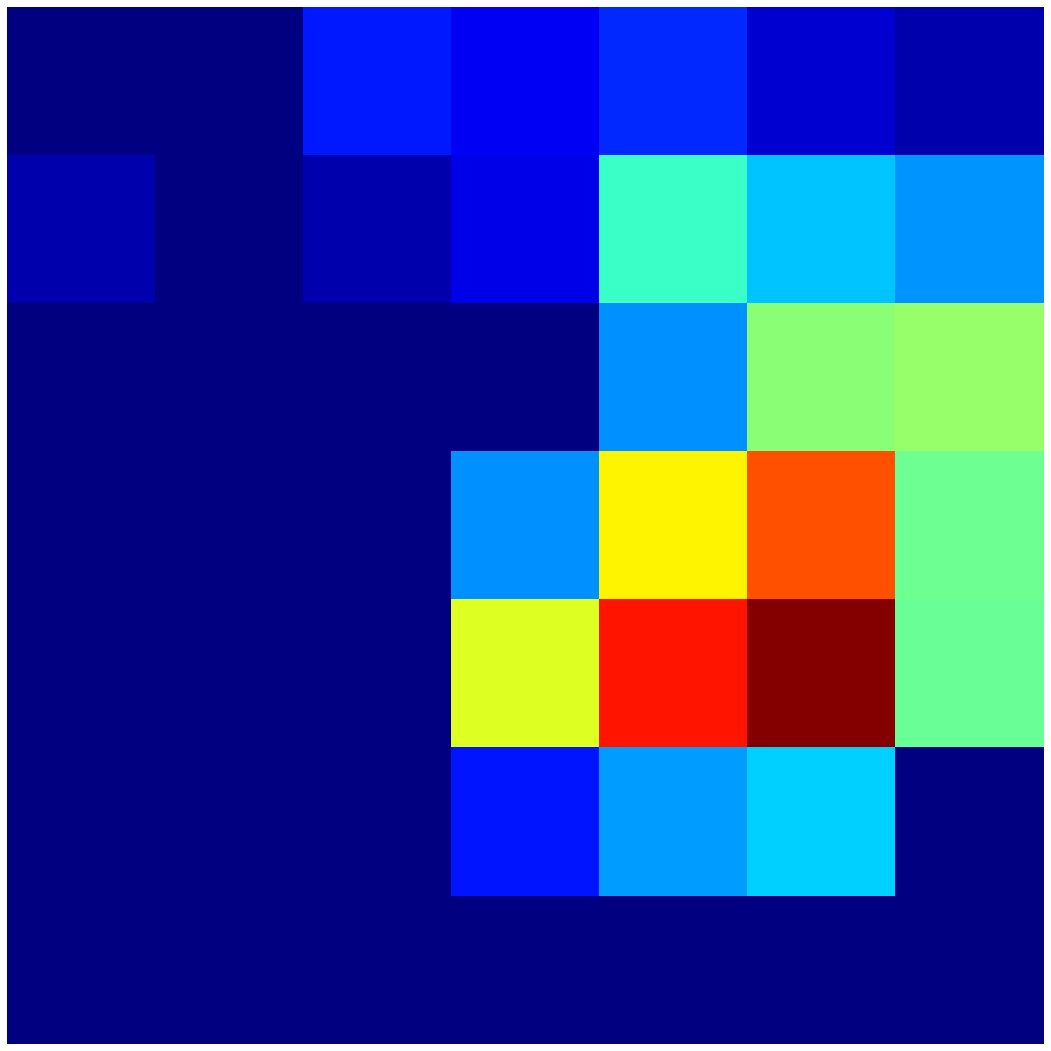

In [112]:
x= resnet.conv1(image_origin)

x = resnet.bn1(x)
x = resnet.relu(x)
x = resnet.maxpool(x)

x = resnet.layer1(x)
x = resnet.layer2(x)
x = resnet.layer3(x)
x = resnet.layer4(x)

print(x.shape)
draw_features(1, 1, x.cpu().detach().numpy())

In [113]:
x.shape

torch.Size([1, 512, 7, 7])

load image from:  ../data/mm/TV/MVSA_SINGLE/data/3.jpg


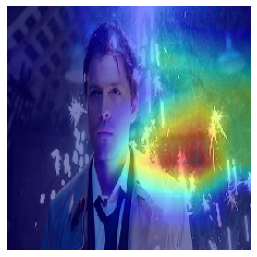

In [116]:
visualize_grid_attention_v2('../data/mm/TV/MVSA_SINGLE/data/3.jpg',x.squeeze()[0].cpu().detach().numpy())

In [117]:
image_size=224
transform_base = transforms.Compose(
    [
        transforms.Resize(get_resize(image_size)),
        transforms.ToTensor()
    ]
)
image_path = '../data/mm/TV/MVSA_SINGLE/data/3.jpg'
image_read = Image.open(image_path)
image_read.load()

image_origin =  transform_base(image_read)

In [120]:
image_origin=image_origin.unsqueeze(0)

In [121]:
image_origin.shape

torch.Size([1, 3, 256, 457])

In [146]:
resnet = cv_models.resnet18(pretrained=True)


torch.Size([1, 512, 8, 15])
(8, 15)
time:0.01982712745666504


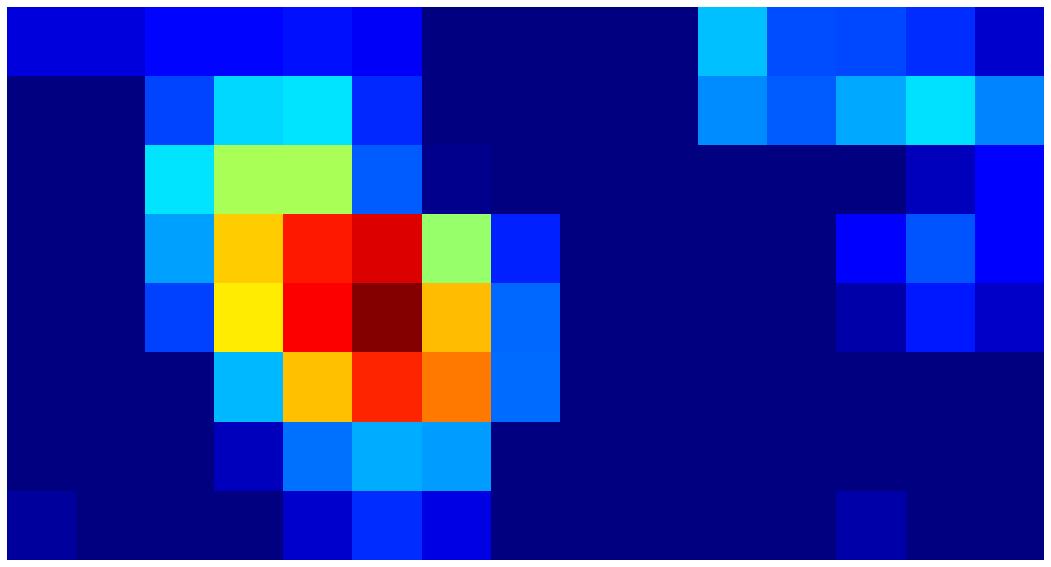

In [147]:
x= resnet.conv1(image_origin)

x = resnet.bn1(x)
x = resnet.relu(x)
x = resnet.maxpool(x)

x = resnet.layer1(x)
x = resnet.layer2(x)
x = resnet.layer3(x)
x = resnet.layer4(x)

print(x.shape)
draw_features(1, 1, x.cpu().detach().numpy())

load image from:  ../data/mm/TV/MVSA_SINGLE/data/3.jpg


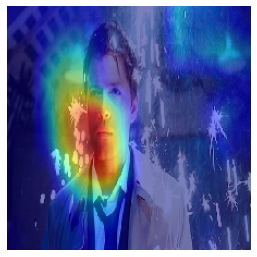

In [148]:
visualize_grid_attention_v2('../data/mm/TV/MVSA_SINGLE/data/3.jpg',x.squeeze()[0].cpu().detach().numpy())

In [150]:
resnet_encoder=nn.Sequential(*(list(resnet.children())[:-2]))

In [153]:
resnet_avgpool=nn.Sequential((list(resnet.children())[-2]))

In [151]:
resnet_encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [154]:
resnet_avgpool

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [155]:
resnet_avgpool=nn.Sequential((list(resnet.children())[-1]))

In [156]:
resnet_avgpool

Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
)